# NDVI Time series

## Metodologia:
- Ler um shapefile com poligonos
- Obter a série histórica das imagens filtradando as nuvens
- Calcular o NDVI para cada imagem
- Para cada poligono obter a serie histórica


## Referências:

- https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/ndvi_hotspots.ipynb



# Setup

In [110]:
import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio as rio
import rioxarray as rioxr
import xarray as xr

import pystac
import pystac_client
import stackstac
import planetary_computer

import matplotlib.pyplot as plt
import xrspatial.multispectral as ms

pd.set_option('display.max_columns', 50)

# Read

In [112]:
gdf_polygons = gpd.read_file('../data/farm_polygons.geojson')

In [113]:
bbox = gdf_polygons.geometry.envelope.bounds.values[0]

## Sentinel collection

In [114]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
   modifier=planetary_computer.sign_inplace
)

In [115]:
sentinel = catalog.get_collection("sentinel-2-l2a")

# what Assets are available on our item
pd.DataFrame.from_dict(sentinel.extra_fields["item_assets"], orient="index")

gsd                                               type  \
AOT                 10.0  image/tiff; application=geotiff; profile=cloud...   
B01                 60.0  image/tiff; application=geotiff; profile=cloud...   
B02                 10.0  image/tiff; application=geotiff; profile=cloud...   
B03                 10.0  image/tiff; application=geotiff; profile=cloud...   
B04                 10.0  image/tiff; application=geotiff; profile=cloud...   
B05                 20.0  image/tiff; application=geotiff; profile=cloud...   
B06                 20.0  image/tiff; application=geotiff; profile=cloud...   
B07                 20.0  image/tiff; application=geotiff; profile=cloud...   
B08                 10.0  image/tiff; application=geotiff; profile=cloud...   
B09                 60.0  image/tiff; application=geotiff; profile=cloud...   
B11                 20.0  image/tiff; application=geotiff; profile=cloud...   
B12                 20.0  image/tiff; application=geotiff; profile=cloud...   
B8A                 20.0  image/tiff; application=geotiff; profile=cloud...   
SCL                 20.0  image/tiff; application=geotiff; profile=cloud...   
WVP                 10.0  image/tiff; application=geotiff; profile=cloud...   
visual              10.0  image/tiff; application=geotiff; profile=cloud...   
preview              NaN  image/tiff; application=geotiff; profile=cloud...   
safe-manifest        NaN                                    application/xml   
granule-metadata     NaN                                    application/xml   
inspire-metadata     NaN                                    application/xml   
product-metadata     NaN                                    application/xml   
datastrip-metadata   NaN                                    application/xml   

                          roles                                  title  \
AOT                      [data]        Aerosol optical thickness (AOT)   
B01                      [data]         Band 1 - Coastal aerosol - 60m   
B02                      [data]                    Band 2 - Blue - 10m   
B03                      [data]                   Band 3 - Green - 10m   
B04                      [data]                     Band 4 - Red - 10m   
B05                      [data]   Band 5 - Vegetation red edge 1 - 20m   
B06                      [data]   Band 6 - Vegetation red edge 2 - 20m   
B07                      [data]   Band 7 - Vegetation red edge 3 - 20m   
B08                      [data]                     Band 8 - NIR - 10m   
B09                      [data]             Band 9 - Water vapor - 60m   
B11                      [data]             Band 11 - SWIR (1.6) - 20m   
B12                      [data]             Band 12 - SWIR (2.2) - 20m   
B8A                      [data]  Band 8A - Vegetation red edge 4 - 20m   
SCL                      [data]          Scene classfication map (SCL)   
WVP                      [data]                     Water vapour (WVP)   
visual                   [data]                       True color image   
preview             [thumbnail]                              Thumbnail   
safe-manifest        [metadata]                          SAFE manifest   
granule-metadata     [metadata]                       Granule metadata   
inspire-metadata     [metadata]                       INSPIRE metadata   
product-metadata     [metadata]                       Product metadata   
datastrip-metadata   [metadata]                     Datastrip metadata   

                                                             eo:bands  
AOT                                                               NaN  
B01                 [{'name': 'B01', 'common_name': 'coastal', 'de...  
B02                 [{'name': 'B02', 'common_name': 'blue', 'descr...  
B03                 [{'name': 'B03', 'common_name': 'green', 'desc...  
B04                 [{'name': 'B04', 'common_name': 'red', 'descri...  
B05                 [{'name': 'B05', 'common_name': 'rededge', 'de..

# Search images
- TO DO:
    - Mascara de nuvem Mask cloudy pixels using the QA band

In [116]:
search = catalog.search(collections=["sentinel-2-l2a"],
                        bbox=bbox,
                        datetime="2020-01-01/2022-12-30",
                        query={"eo:cloud_cover": {"lt": 20}})
items = search.get_all_items()
len(items)

94

In [117]:
# inspect the rendered_preview asset.
selected_item = items[2]
print(selected_item)
selected_item.assets["rendered_preview"].to_dict()

from IPython.display import Image
Image(url=selected_item.assets["rendered_preview"].href, width=500)

<Item id=S2B_MSIL2A_20220913T135709_R067_T21LXF_20220914T044932>


# Processing
- 1. Search images for the AOI
- 2. Compute NDVI time series (polygon montlhy median)

### TO DO:
- plot time series por one point
- take the median for the polygon by month

### with stackstac
- https://stackstac.readthedocs.io/en/latest/basic.html

In [63]:
items = search.item_collection()

data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=100,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        chunksize=256,  # set chunk size to 256 to get one chunk per time step
        bounds_latlon=bbox # clip to our area of interest
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(
        # band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round("D"),  # round time to daily for nicer plot labels
    )
)
data

<xarray.DataArray 'stackstac-2fab7866a032119ce8aaf1d8154ec488' (time: 94,
                                                                band: 4, y: 29,
                                                                x: 28)>
dask.array<where, shape=(94, 4, 29, 28), dtype=float64, chunksize=(1, 1, 29, 28), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2020-04-22...
    id                                       (time) <U54 'S2A_MSIL2A_20200421...
  * band                                     (band) <U3 'B02' 'B03' 'B04' 'B08'
  * x                                        (x) float64 1.939e+06 ... 1.942e+06
  * y                                        (y) float64 -1.489e+06 ... -1.49...
    s2:medium_proba_clouds_percentage        (time) float64 2.366 ... 1.257
    ...                                       ...
    gsd                                      float64 10.0
    proj:transform                           object {0.0, 600000.0, 10.0, 860...
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int32 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(1938900, -1492100, 1941700, -...
    crs:         epsg:32619
    transform:   | 100.00, 0.00, 1938900.00|\n| 0.00,-100.00,-1489200.00|\n| ...
    resolution:  100

In [65]:
monthly = data.resample(time='M').median()

#clip to polygon
monthly = monthly.rio.clip(gdf_polygons.geometry.values, gdf_polygons.crs, drop=True, invert=False)

# user 
ndvi_aggs = [ms.ndvi(x.sel(band="B08"), x.sel(band="B04")) for x in monthly]

ndvi = xr.concat(ndvi_aggs, dim="time")

In [66]:
# Persist to memory

# ndvi.compute().plot()
df = ndvi.to_dataframe().reset_index()

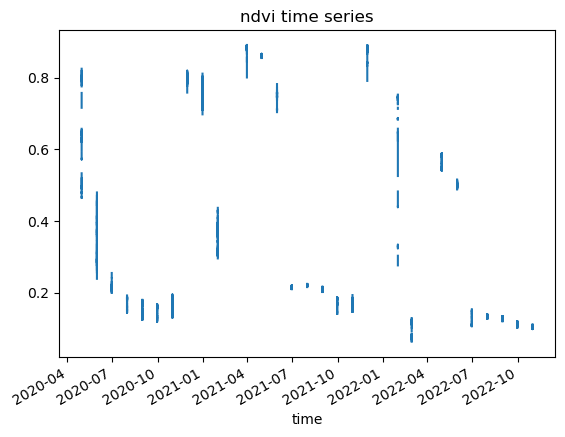

In [27]:
df["time"] = pd.to_datetime(df["time"])

ts = df.set_index("time").sort_index()["ndvi"].rolling(12).mean()
ts.plot(title="ndvi time series");

<Axes: xlabel='time'>

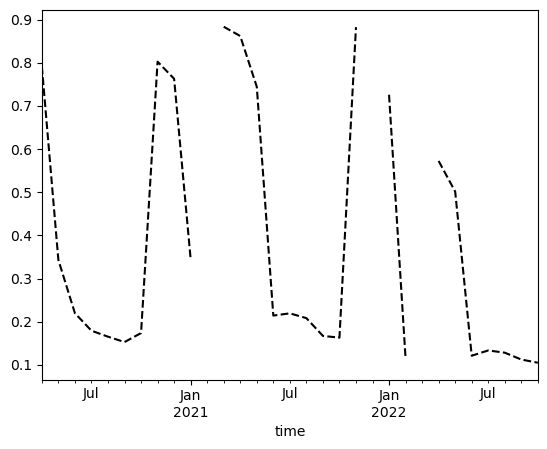

In [28]:
df.groupby('time').ndvi.median().plot(style='k--')

In [30]:
import shapely
import folium


#converter o xarray em geodataframde de pontos
gdf = gpd.GeoDataFrame(
    df.ndvi, geometry=gpd.points_from_xy(df.x,df.y), 
    crs="EPSG:32619")

# cria a visualização com o geopandas explore
m = gdf.explore(column='ndvi')

# adiciona o poligono ao mapa
bbox_layer = folium.GeoJson(gdf_polygons.geometry[0])
bbox_layer.add_to(m)
m

### Define UDF function

In [147]:
def ndvi_ts(aoi, polygon_id, crs,start_date=None, end_date=None, max_cloud_cover=None, resolution=None ):
    """
    Find a STAC item that intersects the area of interest (aoi)

    Parameters
    ----------
    aoi : geopandas.GeoDataFrame polygon
    start_date :
    end_date : 
    max_cloud_cover: max percentagem cloud cover on image

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    aoi = gpd.GeoSeries(aoi.geometry)
    aoi.crs = crs
    intersects = aoi[0].envelope.bounds
    search_start = start_date
    search_end = end_date
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace
    )

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=intersects,
    datetime=[search_start, search_end],
    query={"eo:cloud_cover": {"lt": max_cloud_cover}}
    )

    items = search.item_collection()
    print('items received {}'.format(len(items)))

    data = (
        stackstac.stack(
            items,
            epsg=32619,
            resolution=resolution,
            assets=["B04", "B08"],  # blue, green, red, nir
            chunksize=256,  # set chunk size to 256 to get one chunk per time step
            bounds_latlon=aoi[0].envelope.bounds # clip to our area of interest
        )
        .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
        .assign_coords(
            # band=lambda x: x.common_name.rename("band"),  # use common names
            time=lambda x: x.time.dt.round("D"),  # round time to daily for nicer plot labels
        )
    )
    print('data stack set')
    monthly = data.resample(time='M').median()

    # #clip to polygon
    monthly = monthly.rio.clip(aoi.geometry.values, crs=crs , drop=True, invert=False)

    # # user 
    ndvi_aggs = [ms.ndvi(x.sel(band="B08"), x.sel(band="B04")) for x in monthly]
    ndvi = xr.concat(ndvi_aggs, dim="time")
    df=ndvi.to_dataframe().reset_index()
    df['aoi_id'] = polygon_id

    return df

#### Apply UDF function to each polygon aoi

In [150]:
df_results = pd.DataFrame()
crs = gdf_polygons.crs
search_start = "2019-05-01"
search_end = "2022-10-30"
resolution = 100
max_cloud_cover = 10
for i, x in gdf_polygons.iterrows():
    # print(type(x.values[0]))
    df_results = pd.concat([df_results, ndvi_ts(x, i,  crs, search_start, search_end, max_cloud_cover, resolution)])

items received 99
data stack set


<Axes: >

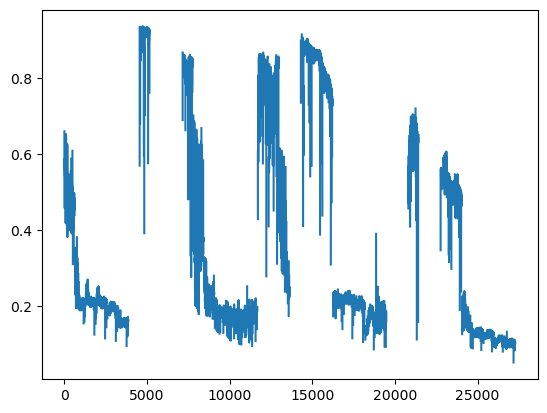

In [153]:
df_results.ndvi.plot()

<Axes: xlabel='time'>

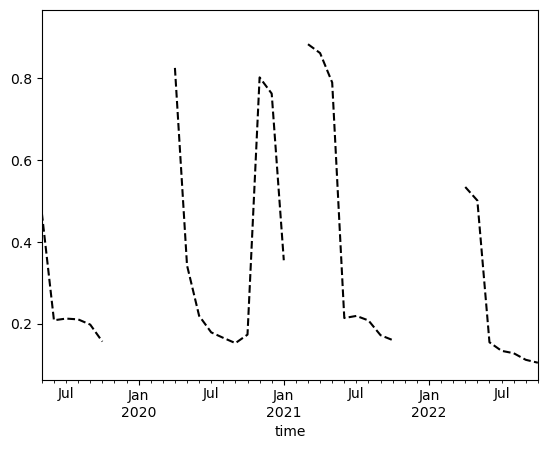

In [154]:
df_results.groupby('time').ndvi.median().plot(style='k--')